In [50]:
%pip install -r requirements_part1.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
# Imports
import pandas as pd
from transformers import pipeline


In [52]:
# Load training data
df_all_features = pd.read_csv('liar2/train.csv')

df_all_features.head(3)

,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,half_true_counts,mostly_false_counts,false_counts,pants_on_fire_counts,context,justification
0,13847,5,"90 percent of Americans ""support universal bac...","October 2, 2017",government regulation;polls and public opinion...,chris abele,"Chris Abele is Milwaukee County Executive, a p...",wisconsin,1,4,5,3,5,2,a tweet,"""Universal"" is the term for background checks ..."
1,13411,1,Last year was one of the deadliest years ever ...,"May 19, 2017",after the fact;congress;criminal justice;histo...,thom tillis,Thom Tillis is a Republican who serves as U.S....,north carolina,0,2,7,3,2,0,a press release supporting the Back The Blue A...,"Sen. Thom Tillis, a North Carolina Republican,..."
2,10882,0,"Bernie Sanders's plan is ""to raise your taxes ...","October 28, 2015",taxes,chris christie,"Chris Christie announced June 6, 2023 that he ...",national,21,20,27,11,17,8,"Boulder, Colo","Christie said that Sanders’s plan is ""to raise..."


In [53]:
df = df_all_features[["statement", "label"]]
df.head(3)

,statement,label
0,"90 percent of Americans ""support universal bac...",5
1,Last year was one of the deadliest years ever ...,1
2,"Bernie Sanders's plan is ""to raise your taxes ...",0


# 1. RoBERT - Jean-Baptiste/roberta-large-ner-english
- PER (Person names)
- ORG (Organizations)
- LOC (Locations)
- MISC (Other special entities)

In [2]:

# Load RoBERTa NER model
ner_pipeline_roberta = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english")

def clean_entity(entity):
    """Removes tokenization artifacts and filters out unwanted characters."""
    word = entity["word"].replace("Ġ", "").strip()  # Remove subword markers
    if len(word) > 1 and word.isalpha():  # Keep only proper words
        return (word, entity["entity"])
    return None  # Ignore bad entities

def extract_entities(text):
    """Runs RoBERTa NER and cleans extracted entities."""
    if isinstance(text, str) and text.strip():
        entities = ner_pipeline_roberta(text)
        return [e for e in (clean_entity(ent) for ent in entities) if e]  # Apply filtering
    return []

# Apply NER extraction + cleaning
df_RoBert = df.copy()
df_RoBert.loc[:, "clean_entities"] = df["statement"].apply(extract_entities)

# Show first few rows
df_RoBert

NameError: name 'pipeline' is not defined

In [ ]:
true_labels = [3,4, 5]   # True, Mostly-true,    .............Half-true will be skipped
false_labels = [0, 1,2]  # Mostly-false will be skipped.....,False, Pants on Fire

# Split into true and false news DataFrames
df_RoBert_true = df_RoBert[df_RoBert["label"].isin(true_labels)]
df_RoBert_false = df_RoBert[df_RoBert["label"].isin(false_labels)]

NameError: name 'df_RoBert' is not defined

In [ ]:
df_RoBert_false.head(3)

,statement,label,clean_entities
1,Last year was one of the deadliest years ever ...,1,[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,"[(Bernie, PER), (Sanders, PER)]"
4,"Says Barack Obama ""robbed Medicare (of) $716 b...",2,"[(Barack, PER), (Obama, PER), (Medicare, MISC)..."


In [ ]:
df_RoBert_true.head(3)

,statement,label,clean_entities
0,"90 percent of Americans ""support universal bac...",5,"[(Americans, MISC)]"
3,Voter ID is supported by an overwhelming major...,4,"[(NY, MISC), (ers, MISC)]"
7,One in three women is sexually assaulted on th...,3,[]


In [ ]:
import pandas as pd
from collections import Counter

def count_entities_with_type(df):
    """Counts occurrences of each entity (name, type) and returns a DataFrame."""
    all_entities = [
        (entity[0], entity[1]) for entities in df["clean_entities"] if entities for entity in entities
    ]
    
    entity_counts = Counter(all_entities).most_common()  # Count all entities

    # ✅ Fix: Unpack entity tuple correctly
    df_entities = pd.DataFrame(
        [(ent[0], ent[1], count) for ent, count in entity_counts],
        columns=["Entity", "Type", "Count"]
    )

    return df_entities

# Apply to true and false news
df_RoBert_true_entities = count_entities_with_type(df_RoBert_true)
df_RoBert_false_entities = count_entities_with_type(df_RoBert_false)


df_RoBert_false_entities.head(10)


,Entity,Type,Count
0,Obama,PER,662
1,Trump,PER,637
2,Biden,PER,494
3,CO,MISC,408
4,VID,MISC,406
5,Joe,PER,328
6,Donald,PER,307
7,Barack,PER,263
8,Democrats,MISC,234
9,Wisconsin,LOC,230


In [ ]:
df_RoBert_true_entities.head(10)

,Entity,Type,Count
0,Obama,PER,415
1,Texas,LOC,284
2,Trump,PER,253
3,Americans,MISC,245
4,United,LOC,227
5,States,LOC,223
6,American,MISC,207
7,Wisconsin,LOC,199
8,Florida,LOC,183
9,New,LOC,177


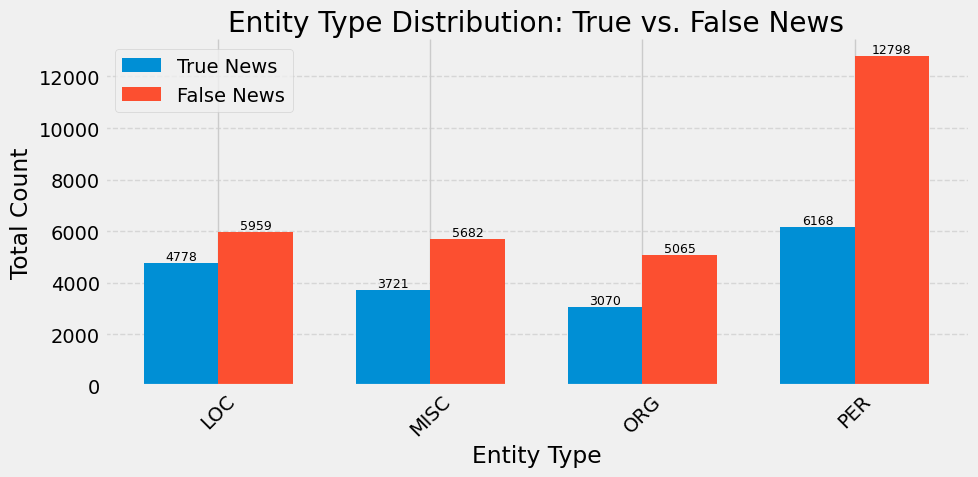

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If not already imported:
# import pandas as pd

# 1) Group and sum counts by entity Type
true_counts = df_RoBert_true_entities.groupby("Type")["Count"].sum()
false_counts = df_RoBert_false_entities.groupby("Type")["Count"].sum()

# 2) Collect all entity types from both true and false
all_types = sorted(set(true_counts.index).union(set(false_counts.index)))

# 3) Reindex so both series have the same index order
true_counts = true_counts.reindex(all_types, fill_value=0)
false_counts = false_counts.reindex(all_types, fill_value=0)

# 4) Set positions for the bars
x = np.arange(len(all_types))
width = 0.35  # bar width

# 5) Use a modern style
plt.style.use('fivethirtyeight')

# 6) Create the figure
plt.figure(figsize=(10, 5))

# 7) Plot bars side by side
bars_true = plt.bar(x - width/2, true_counts, width, label="True News")
bars_false = plt.bar(x + width/2, false_counts, width, label="False News")

# 8) Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 9) Remove top/right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 10) Labels, title, legend
plt.xlabel("Entity Type")
plt.ylabel("Total Count")
plt.title("Entity Type Distribution: True vs. False News")
plt.xticks(x, all_types, rotation=45)
plt.legend()

# 11) (Optional) Annotate bars with exact values
for bar_group in [bars_true, bars_false]:
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height}",
                ha="center",
                va="bottom",
                fontsize=9
            )

plt.tight_layout()
plt.show()

# 2. RoBERT - dbmdz/bert-large-cased-finetuned-conll03-english
- PER (Person names)
- ORG (Organizations)
- LOC (Locations)

In [ ]:
ner_pipeline_bert = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

df_RoBert_dbmdz = df.copy()
df_RoBert_dbmdz.loc[:, "clean_entities"] = df["statement"].apply(extract_entities)

# Show first few rows
df_RoBert_dbmdz

